<h1><center> COSC 4337 Data Science II Second Milestone</center></h1>

## Data Loading & Pre-processing

In [1]:
import pandas as pd

data = pd.read_csv('SoilOrganicCarbonRecovery_NorthwestTerritories.csv')
print(data.head())

print("Null values found in columns:")
data.isnull().sum()

# 2. Drop rows with missing data
data.dropna(inplace=True)
data.isnull().sum()

     plot burn   site        date  decid_prop_canopy  piba_prop_canopy  \
0  C1-14A   C1  C1-14  2018-06-13           0.032258          0.709677   
1  C1-17A   C1  C1-17  2018-06-10           0.000000          0.000000   
2  C1-19A   C1  C1-19  2018-06-13           0.000000          0.000000   
3  C1-19B   C1  C1-19  2018-06-13           0.000000          0.650000   
4  C1-21A   C1  C1-21  2018-06-14           0.023529          0.000000   

  stand_dominance  time_after_fire moisture nonvascular_functionalgroup  \
0       Jack Pine               83    Xeric                      Lichen   
1    Black Spruce               65    Mesic                      Lichen   
2    Black Spruce               82   Hydric                    Sphagnum   
3       Jack Pine               84    Xeric                      Lichen   
4    Black Spruce               79   Hydric                  Colonizers   

   avg_org_carbon ecozone  avg_carbon_stock   latitude  longitude   
0            4.05  shield          

plot                           0
burn                           0
site                           0
date                           0
decid_prop_canopy              0
piba_prop_canopy               0
stand_dominance                0
time_after_fire                0
moisture                       0
nonvascular_functionalgroup    0
avg_org_carbon                 0
ecozone                        0
avg_carbon_stock               0
latitude                       0
longitude                      0
dtype: int64

### Linear Model - Radhika Sonde

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# correlation matrix
column_indices = [4, 5, 7, 10, 12]
subset_data = data.iloc[:, column_indices]
correlation_matrix = subset_data.corr()

# Formatting
correlation_df = pd.DataFrame(correlation_matrix)
correlation_df = correlation_df.round(4)

# Print the correlation matrix with nicer formatting
print("Correlation Matrix:")
print(correlation_df.to_string())

Correlation Matrix:
                   decid_prop_canopy  piba_prop_canopy  time_after_fire  avg_org_carbon  avg_carbon_stock
decid_prop_canopy             1.0000           -0.0695           0.0394         -0.2634           -0.2826
piba_prop_canopy             -0.0695            1.0000           0.1470         -0.3906           -0.3781
time_after_fire               0.0394            0.1470           1.0000          0.1162            0.0335
avg_org_carbon               -0.2634           -0.3906           0.1162          1.0000            0.8105
avg_carbon_stock             -0.2826           -0.3781           0.0335          0.8105            1.0000


<u>First Linear Model</u>

In [4]:
# Building linear model
model = sm.OLS(data['avg_org_carbon'], sm.add_constant(data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']])).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_org_carbon   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     195.5
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           1.39e-89
Time:                        22:17:14   Log-Likelihood:                -1331.8
No. Observations:                 372   AIC:                             2674.
Df Residuals:                     367   BIC:                             2693.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5300      1.05

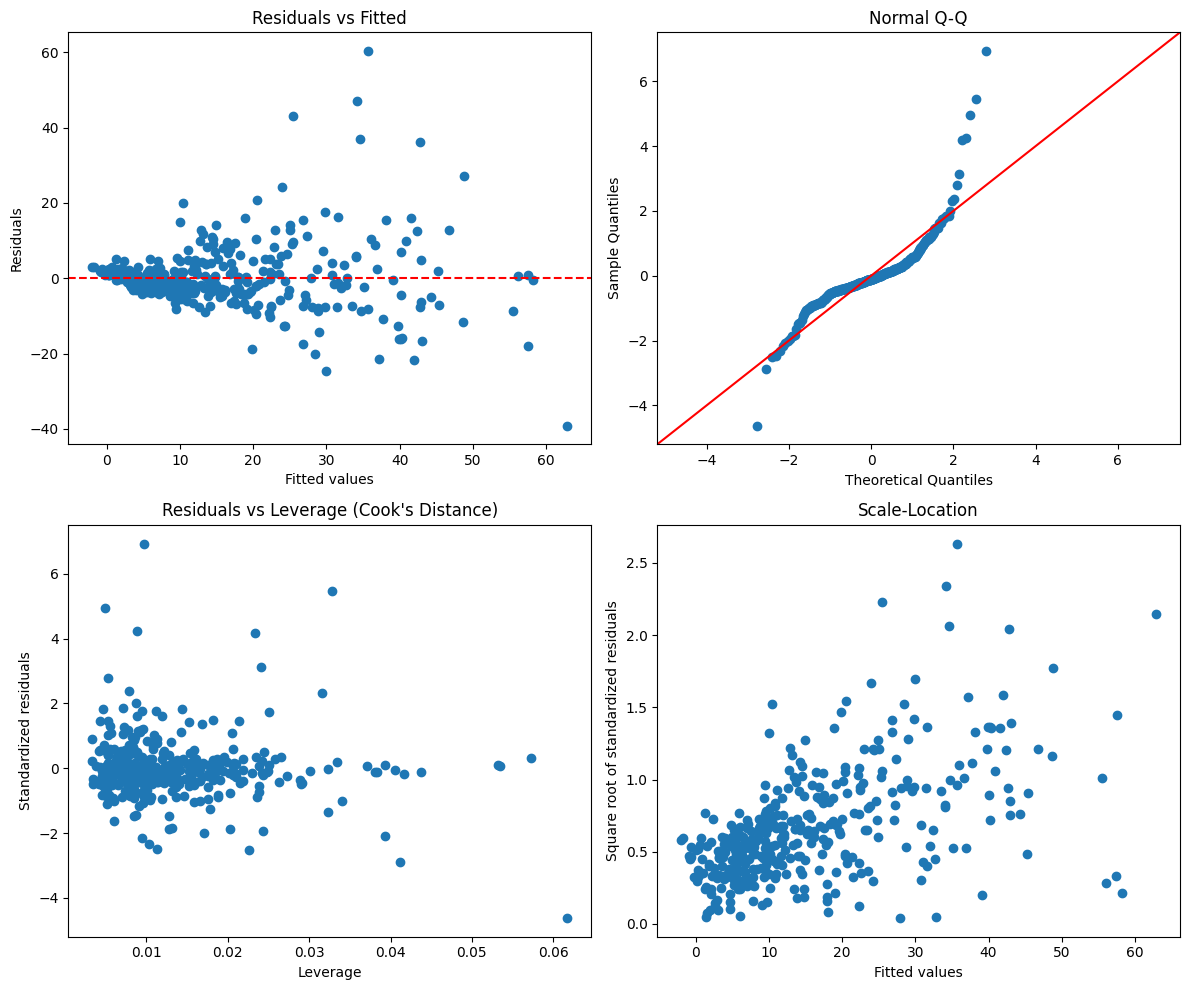

In [16]:
# Compute Cook's distance
influence = model.get_influence()

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
residuals = model.resid
fitted = model.fittedvalues
axes[0, 0].scatter(fitted, residuals)
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# Normal Q-Q plot
residuals_standardized = influence.resid_studentized_internal
sm.qqplot(residuals_standardized, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# Residuals vs Leverage plot with Cook's distance
axes[1, 0].scatter(influence.hat_matrix_diag, residuals_standardized)
axes[1, 0].set_xlabel('Leverage')
axes[1, 0].set_ylabel("Standardized residuals")
axes[1, 0].set_title("Residuals vs Leverage (Cook's Distance)")

# Scale-location plot
sqrt_abs_standardized_resid = np.sqrt(np.abs(residuals_standardized))
axes[1, 1].scatter(fitted, sqrt_abs_standardized_resid)
axes[1, 1].set_xlabel('Fitted values')
axes[1, 1].set_ylabel('Square root of standardized residuals')
axes[1, 1].set_title('Scale-Location')

plt.tight_layout()
plt.show()


<u>Step Function</u>

In [20]:
# Perform stepwise selection
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        new_aic = {}
        new_rss = {}
        new_bic = {}
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
            new_aic[new_column] = model.aic
            new_rss[new_column] = model.ssr
            new_bic[new_column] = model.bic
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature:30} with p-value {best_pval:.6}, AIC: {new_aic[best_feature]:.6}, RSS: {new_rss[best_feature]:.6}, BIC: {new_bic[best_feature]:.6}')

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


# Selecting predictors
X = data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']]

# Add constant for the intercept term
X = add_constant(X)

# Define the dependent variable
y = data['avg_org_carbon']

result = stepwise_selection(X, y)

# Print selected features
print("Selected features:", result)

Add  avg_carbon_stock               with p-value 5.89772e-88, AIC: 2694.21, RSS: 30114.5, BIC: 2702.05
Add  const                          with p-value 0.000151645, AIC: 2694.21, RSS: 30114.5, BIC: 2702.05
Add  piba_prop_canopy               with p-value 0.00273351, AIC: 2687.15, RSS: 29389.7, BIC: 2698.9
Add  time_after_fire                with p-value 0.000380027, AIC: 2676.36, RSS: 28397.0, BIC: 2692.04
Selected features: ['avg_carbon_stock', 'const', 'piba_prop_canopy', 'time_after_fire']


<u>Performance Model Evaluation</u>

In [6]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Selecting predictors
X = data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']]
y = data['avg_org_carbon']

# Adding constant to the features
X = sm.add_constant(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the linear model
model = sm.OLS(y_train, X_train).fit()

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)


Mean Squared Error: 77.85351306495022


<u>Transforming to Normalize Data</u>

In [8]:
transformed_data = data.copy()  # Copy the original DataFrame
numeric_vars = transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire', 'avg_org_carbon']]

# Logarithmic transformation
log_transformed_data = numeric_vars.apply(np.log1p)
# Update the transformed data back to the original DataFrame
transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire', 'avg_org_carbon']] = log_transformed_data


In [21]:
# Building linear model with transformed data
model3 = sm.OLS(transformed_data['avg_org_carbon'], sm.add_constant(transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']])).fit()

# Summary of linear regression model
print("\nSummary of Linear Regression Model with Transformed Data:")
print(model3.summary())


Summary of Linear Regression Model with Transformed Data:
                            OLS Regression Results                            
Dep. Variable:         avg_org_carbon   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     419.1
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          2.21e-135
Time:                        17:31:09   Log-Likelihood:                -175.29
No. Observations:                 372   AIC:                             360.6
Df Residuals:                     367   BIC:                             380.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

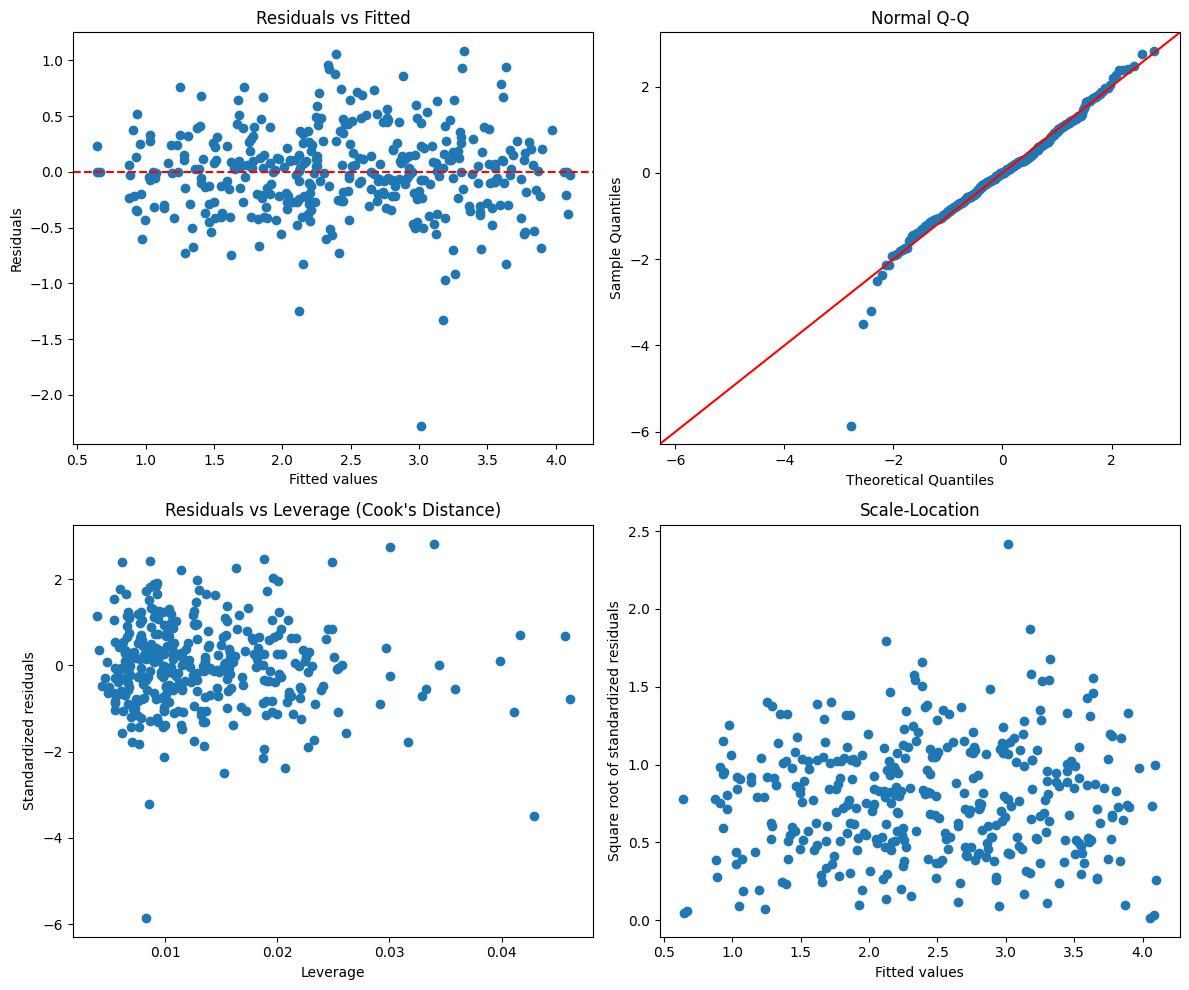

In [22]:
# Compute Cook's distance
influence = model3.get_influence()

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
residuals = model3.resid
fitted = model3.fittedvalues
axes[0, 0].scatter(fitted, residuals)
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# Normal Q-Q plot
residuals_standardized = influence.resid_studentized_internal
sm.qqplot(residuals_standardized, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# Residuals vs Leverage plot with Cook's distance
axes[1, 0].scatter(influence.hat_matrix_diag, residuals_standardized)
axes[1, 0].set_xlabel('Leverage')
axes[1, 0].set_ylabel("Standardized residuals")
axes[1, 0].set_title("Residuals vs Leverage (Cook's Distance)")

# Scale-location plot
sqrt_abs_standardized_resid = np.sqrt(np.abs(residuals_standardized))
axes[1, 1].scatter(fitted, sqrt_abs_standardized_resid)
axes[1, 1].set_xlabel('Fitted values')
axes[1, 1].set_ylabel('Square root of standardized residuals')
axes[1, 1].set_title('Scale-Location')

plt.tight_layout()
plt.show()


<u> Step Function for Transformed Data </u>

In [19]:
X_transform = transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']]

# Add constant for the intercept term
X_transform = add_constant(X_transform)

# Define the dependent variable
y_tranform = transformed_data['avg_org_carbon']

result = stepwise_selection(X_transform, y_tranform)

# Print selected features
print("Selected features:", result)

Add  const                          with p-value 3.12832e-170, AIC: 991.315, RSS: 311.209, BIC: 995.234
Add  avg_carbon_stock               with p-value 1.71818e-124, AIC: 426.431, RSS: 67.8014, BIC: 434.269
Add  time_after_fire                with p-value 4.34132e-07, AIC: 402.652, RSS: 63.2621, BIC: 414.409
Add  piba_prop_canopy               with p-value 9.47616e-09, AIC: 371.303, RSS: 57.8376, BIC: 386.979
Add  decid_prop_canopy              with p-value 0.000397801, AIC: 360.573, RSS: 55.8917, BIC: 380.167
Selected features: ['const', 'avg_carbon_stock', 'time_after_fire', 'piba_prop_canopy', 'decid_prop_canopy']


<u> Performance Evaluation for Transformed Data </u>

In [12]:
# Selecting predictors
X = transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']]
y = transformed_data['avg_org_carbon']

# Adding constant to the features
X = sm.add_constant(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the linear model
model = sm.OLS(y_train, X_train).fit()

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.22667612184153166


### Clustering \ DBSCAN - Roberto Jackson Baeza

In [87]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import random
from scipy.spatial.distance import cdist


In [90]:
csvdata = pd.read_csv('SoilOrganicCarbonRecovery_NorthwestTerritories.csv')
print(csvdata.head())

     plot burn   site        date  decid_prop_canopy  piba_prop_canopy  \
0  C1-14A   C1  C1-14  2018-06-13           0.032258          0.709677   
1  C1-17A   C1  C1-17  2018-06-10           0.000000          0.000000   
2  C1-19A   C1  C1-19  2018-06-13           0.000000          0.000000   
3  C1-19B   C1  C1-19  2018-06-13           0.000000          0.650000   
4  C1-21A   C1  C1-21  2018-06-14           0.023529          0.000000   

  stand_dominance  time_after_fire moisture nonvascular_functionalgroup  \
0       Jack Pine               83    Xeric                      Lichen   
1    Black Spruce               65    Mesic                      Lichen   
2    Black Spruce               82   Hydric                    Sphagnum   
3       Jack Pine               84    Xeric                      Lichen   
4    Black Spruce               79   Hydric                  Colonizers   

   avg_org_carbon ecozone  avg_carbon_stock   latitude  longitude   
0            4.05  shield          

In [91]:
csvdata.isnull().sum()
csvdata.dropna(inplace=True)
csvdata.reset_index(drop=True, inplace=True)

desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
data = csvdata[desiredColumns]
#print(data.head())
data

,decid_prop_canopy,piba_prop_canopy,time_after_fire,moisture,avg_org_carbon,ecozone,avg_carbon_stock
0,0.032258,0.709677,83,Xeric,4.05,shield,2.557465
1,0.000000,0.000000,65,Mesic,10.70,shield,3.798638
2,0.000000,0.000000,82,Hydric,25.75,shield,2.870864
3,0.000000,0.650000,84,Xeric,5.10,shield,2.092274
4,0.023529,0.000000,79,Hydric,27.95,shield,12.764497
...,...,...,...,...,...,...,...
367,0.920000,0.080000,1,Xeric,1.30,plains,1.390676
368,0.375000,0.500000,1,Xeric,2.70,plains,1.300133
369,0.000000,0.070423,1,Mesic,5.85,plains,3.073747
370,0.000000,0.000000,1,Hydric,20.60,plains,11.539966


In [92]:
ecoMap = {"shield":0 , "plains": 1}
moistMap = {"Xeric":0, "Mesic":0.5, "Hydric":1}
mmNormalizedCols = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]


for col in mmNormalizedCols:
  maxVal = data[col].max()
  minVal = data[col].min()
  data[col] = (data[col] - minVal) / (maxVal - minVal)

data.loc[data["ecozone"] == "shield", "ecozone"] = 0.0
data.loc[data["ecozone"] == "plains", "ecozone"] = 1.0


data.loc[data["moisture"] == "Xeric", "moisture"] = 0.0
data.loc[data["moisture"] == "Mesic", "moisture"] = 0.5
data.loc[data["moisture"] == "Hydric", "moisture"] = 1.0

print(data)

     decid_prop_canopy  piba_prop_canopy  time_after_fire moisture  \
0             0.032625          0.709677         0.828283      0.0   
1             0.000000          0.000000         0.646465      0.5   
2             0.000000          0.000000         0.818182      1.0   
3             0.000000          0.650000         0.838384      0.0   
4             0.023797          0.000000         0.787879      1.0   
..                 ...               ...              ...      ...   
367           0.930455          0.080000         0.000000      0.0   
368           0.379261          0.500000         0.000000      0.0   
369           0.000000          0.070423         0.000000      0.5   
370           0.000000          0.000000         0.000000      1.0   
371           0.233392          0.769231         0.000000      0.0   

     avg_org_carbon ecozone  avg_carbon_stock  
0          0.037677     0.0          0.059010  
1          0.107274     0.0          0.091811  
2          0.26

C:\Users\baeza\AppData\Local\Temp\ipykernel_30628\1211403850.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)
C:\Users\baeza\AppData\Local\Temp\ipykernel_30628\1211403850.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)


In [256]:
def euclideanDistance(point1, point2):
    totalDistance = 0
    for i in range(len(point1)):
        distance = (point1[i] - point2[i])**2
        totalDistance += distance
        
    return np.sqrt(totalDistance)

In [257]:
def getCentroids(data, clusters):
    uniqueClusters = np.unique(clusters)
    centroids = []

    for cluster in uniqueClusters:
        clusterPoints = data[clusters == cluster]
        centroid = np.mean(clusterPoints, axis=0)
        centroids.append(centroid)
        
    return np.array(centroids)

In [258]:
def getTotalWithinClusterVariation(dataWithoutClusters, clusters, centroids):
    totalWithinVariation = 0.0
    clusterCount = len(centroids)

    for i in range(clusterCount):
        clusterPoints = dataWithoutClusters[clusters == i]
        centroid = centroids[i]
        
        distances = [euclideanDistance(point, centroid) for point in clusterPoints]
        withinVariation = np.sum(distances)  
        totalWithinVariation += withinVariation
        
    return totalWithinVariation

In [276]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
basicModel = DBSCAN(eps=0.5, min_samples=5)
basicModel.fit(data[desiredColumns])

clusterLabels = basicModel.labels_
modelCentroids = getCentroids(data[desiredColumns], clusterLabels)
modelVariation = getTotalWithinClusterVariation(data[desiredColumns].values, clusterLabels, modelCentroids)

dataClusters = pd.concat([data, pd.Series(clusterLabels, name='Cluster')], axis=1)

print(dataClusters.head())
print(f"\nTotal Within Cluster Variation for Basic Model: {modelVariation}")

   decid_prop_canopy  piba_prop_canopy  time_after_fire moisture  \
0           0.032625          0.709677         0.828283      0.0   
1           0.000000          0.000000         0.646465      0.5   
2           0.000000          0.000000         0.818182      1.0   
3           0.000000          0.650000         0.838384      0.0   
4           0.023797          0.000000         0.787879      1.0   

   avg_org_carbon ecozone  avg_carbon_stock  Cluster  
0        0.037677     0.0          0.059010        0  
1        0.107274     0.0          0.091811        1  
2        0.264783     0.0          0.067292        2  
3        0.048666     0.0          0.046717        0  
4        0.287807     0.0          0.328750        2  

Total Within Cluster Variation for Basic Model: 380.7815281535923


In [275]:
def RandomizedHillClimbing(data, epsilons, minPoints, answer):
    for i in range(len(minPoints)):
        model = DBSCAN(eps=epsilons[i], min_samples=minPoints[i])
        model.fit(data)
        modelClusterLabels = model.labels_

        modelCentroids = getCentroids(data, modelClusterLabels)
        modelVariation = getTotalWithinClusterVariation(data.values, clusterLabels, modelCentroids)

        if(modelVariation < answer[0] and len(set(modelClusterLabels)) > 2):
            answer[0] = modelVariation
            answer[1] = epsilons[i]
            answer[2] = minPoints[i]
    
    return answer

In [260]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
randomEpsilons = [random.random() for _ in range(50)]
randomMinPoints = [random.randint(3,25) for _ in range(50)]

round1 = RandomizedHillClimbing(data[desiredColumns], randomEpsilons, randomMinPoints, [10000, 0, 0])
print(f"Round 1\nBest Variation: {round1[0]}\nBest Epsilon: {round1[1]}\nBest MinPoints: {round1[2]}")

round2Epsilons = [random.uniform(round1[1]*0.5, round1[1]*1.5) for _ in range(50)]
round2MinPoints = [random.randint(int(round1[2]*0.5),int(round1[2]*1.5)) for _ in range(50)]

round2 = RandomizedHillClimbing(data[desiredColumns], round2Epsilons, round2MinPoints, round1)
print(f"\nRound 2\nBest Variation: {round2[0]}\nBest Epsilon: {round2[1]}\nBest MinPoints: {round2[2]}")

round3Epsilons = [random.uniform(round2[1]*0.75, round2[1]*1.25) for _ in range(50)]
round3MinPoints = [random.randint(int(round2[2]*.75),int(round2[2]*1.25)) for _ in range(50)]

round3 = RandomizedHillClimbing(data[desiredColumns], round3Epsilons, round3MinPoints, round2)
print(f"\nRound 3\nBest Variation: {round3[0]}\nBest Epsilon: {round3[1]}\nBest MinPoints: {round3[2]}")

Round 1
Best Variation: 164.45285989149397
Best Epsilon: 0.22899995094178238
Best MinPoints: 21

Round 2
Best Variation: 160.50878280505583
Best Epsilon: 0.3377938486293094
Best MinPoints: 31

Round 3
Best Variation: 150.8402168100435
Best Epsilon: 0.39159185467602453
Best MinPoints: 34


In [262]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]

bestModel = DBSCAN(eps=round3[1], min_samples=round3[2])
model.fit(data[desiredColumns])
modelClusterLabels = model.labels_
print(set(modelClusterLabels))

dataWithClusters = pd.concat([data[desiredColumns], pd.Series(modelClusterLabels, name="cluster")], axis=1)
print(dataWithClusters)

{0, 1, 2, 3, 4, 5, -1}
     decid_prop_canopy  piba_prop_canopy  time_after_fire moisture  \
0             0.032625          0.709677         0.828283      0.0   
1             0.000000          0.000000         0.646465      0.5   
2             0.000000          0.000000         0.818182      1.0   
3             0.000000          0.650000         0.838384      0.0   
4             0.023797          0.000000         0.787879      1.0   
..                 ...               ...              ...      ...   
367           0.930455          0.080000         0.000000      0.0   
368           0.379261          0.500000         0.000000      0.0   
369           0.000000          0.070423         0.000000      0.5   
370           0.000000          0.000000         0.000000      1.0   
371           0.233392          0.769231         0.000000      0.0   

     avg_org_carbon ecozone  avg_carbon_stock  cluster  
0          0.037677     0.0          0.059010        0  
1          0.107274   

In [263]:
def plotData3D(dataset, x, y, z):
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(dataset[x], dataset[y], dataset[z], c=dataset['cluster'], cmap='viridis')

  pad=10
  ax.set_xlabel(x, labelpad=pad)
  ax.set_ylabel(y, labelpad=pad)
  ax.set_zlabel(z)
  ax.set_title(f"{x} vs {y} vs {z}", pad=pad)

  plt.show()

### CELL BELOW CREATES GRAPHS OF EVERY COMBINATION
### DO NOT RUN UNLESS YOU WANT A MILLION GRAPHS

In [ ]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
combinations_3_elements = list(combinations(desiredColumns, 3))

for combo in combinations_3_elements:
  plotData3D(dataWithClusters, combo[0], combo[1], combo[2])

Graphs for decid_prop_canopy


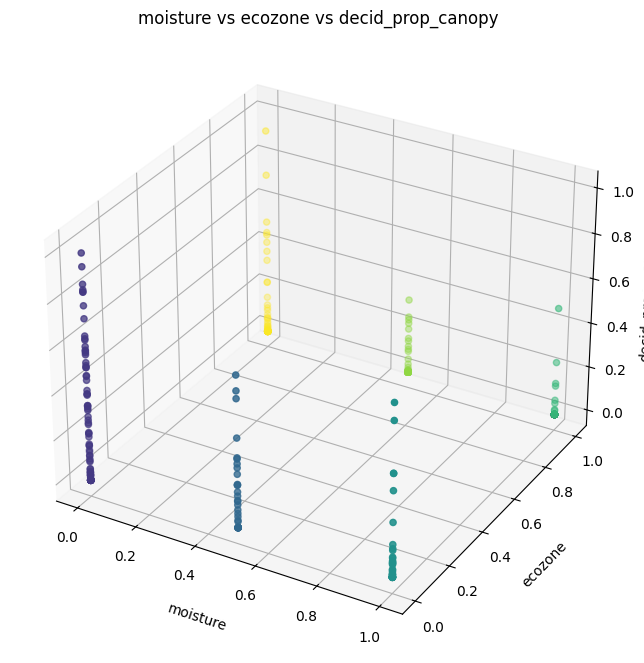

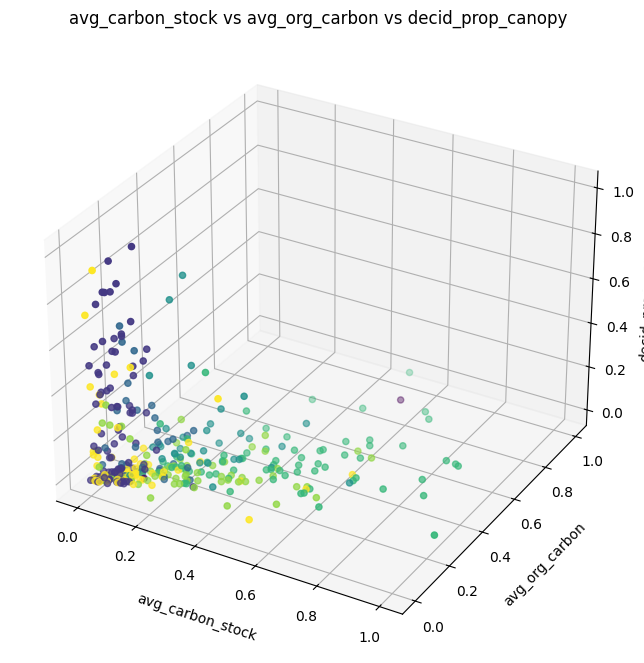

In [264]:
print("Graphs for decid_prop_canopy")
decidGraph1 = ["moisture", "ecozone", "decid_prop_canopy"]
plotData3D(dataWithClusters, decidGraph1[0], decidGraph1[1], decidGraph1[2])

decidGraph2 = ["avg_carbon_stock", "avg_org_carbon", "decid_prop_canopy"]
plotData3D(dataWithClusters, decidGraph2[0], decidGraph2[1], decidGraph2[2])

Graphs for piba_prop_canopy


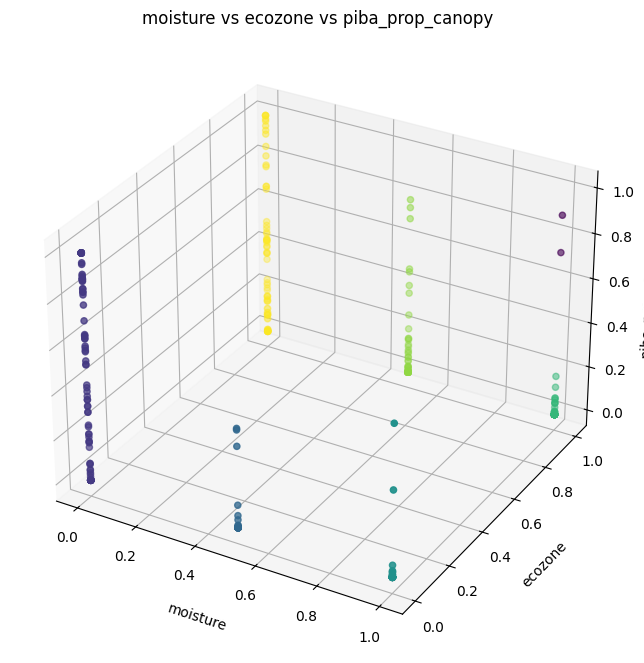

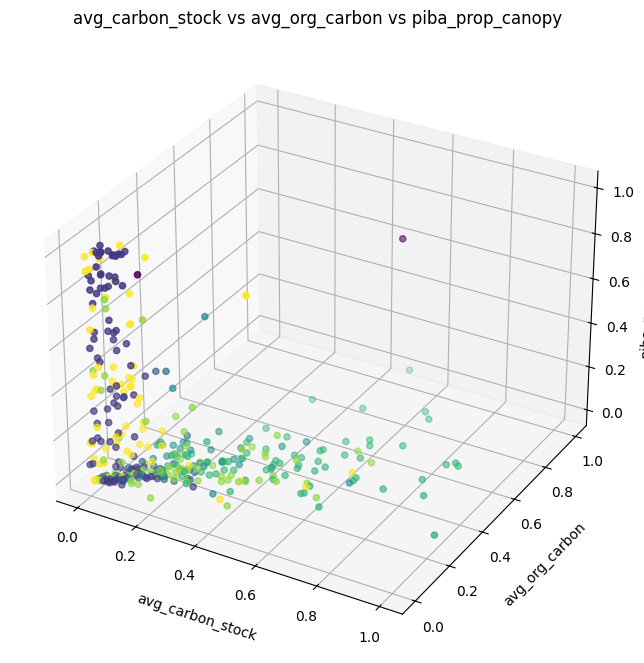

In [265]:
print("Graphs for piba_prop_canopy")
pibaGraph1 = ["moisture", "ecozone", "piba_prop_canopy"]
plotData3D(dataWithClusters, pibaGraph1[0], pibaGraph1[1], pibaGraph1[2])

pibaGraph2 = ["avg_carbon_stock", "avg_org_carbon", "piba_prop_canopy"]
plotData3D(dataWithClusters, pibaGraph2[0], pibaGraph2[1], pibaGraph2[2])

In [269]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]
randomEpsilons = [random.random() for _ in range(50)]
randomMinPoints = [random.randint(3,25) for _ in range(50)]

round1 = RandomizedHillClimbing(data[desiredColumns], randomEpsilons, randomMinPoints, [10000, 0, 0])
print(f"Round 1\nBest Variation: {round1[0]}\nBest Epsilon: {round1[1]}\nBest MinPoints: {round1[2]}")

round2Epsilons = [random.uniform(round1[1]*0.5, round1[1]*1.5) for _ in range(50)]
round2MinPoints = [random.randint(int(round1[2]*0.5),int(round1[2]*1.5)) for _ in range(50)]

round2 = RandomizedHillClimbing(data[desiredColumns], round2Epsilons, round2MinPoints, round1)
print(f"\nRound 2\nBest Variation: {round2[0]}\nBest Epsilon: {round2[1]}\nBest MinPoints: {round2[2]}")

round3Epsilons = [random.uniform(round2[1]*0.75, round2[1]*1.25) for _ in range(50)]
round3MinPoints = [random.randint(int(round2[2]*.75),int(round2[2]*1.25)) for _ in range(50)]

round3 = RandomizedHillClimbing(data[desiredColumns], round3Epsilons, round3MinPoints, round2)
print(f"\nRound 3\nBest Variation: {round3[0]}\nBest Epsilon: {round3[1]}\nBest MinPoints: {round3[2]}")

newModel = DBSCAN(eps=round3[1], min_samples=round3[2])
newModel.fit(data[desiredColumns])
newmodelClusterLabels = newModel.labels_

newdataWithClusters = pd.concat([data[desiredColumns], pd.Series(newmodelClusterLabels, name="cluster")], axis=1)

Round 1
Best Variation: 85.50285491727283
Best Epsilon: 0.23125146963910714
Best MinPoints: 22

Round 2
Best Variation: 85.03027645635181
Best Epsilon: 0.23925930250615274
Best MinPoints: 20

Round 3
Best Variation: 85.03027645635181
Best Epsilon: 0.23925930250615274
Best MinPoints: 20


### CELL BELOW CREATES GRAPHS OF EVERY COMBINATION
### DO NOT RUN UNLESS YOU WANT A MILLION GRAPHS

In [ ]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]
combinations_3_elements = list(combinations(desiredColumns, 3))

for combo in combinations_3_elements:
  plotData3D(newdataWithClusters, combo[0], combo[1], combo[2])

Graph for piba_prop_canopy


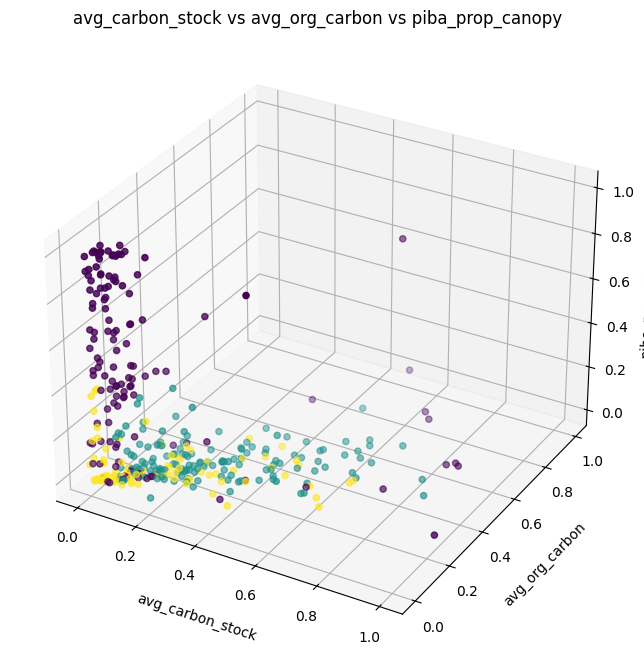

Graph for decid_prop_canopy


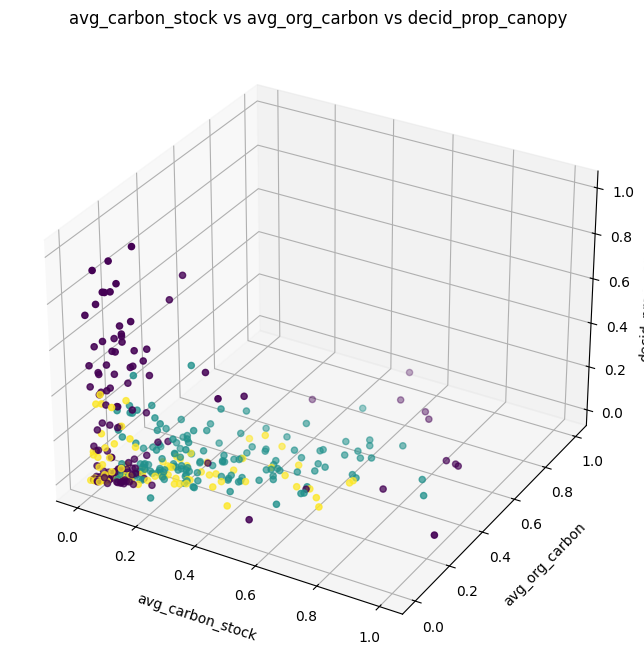

Graph for time_after_fire


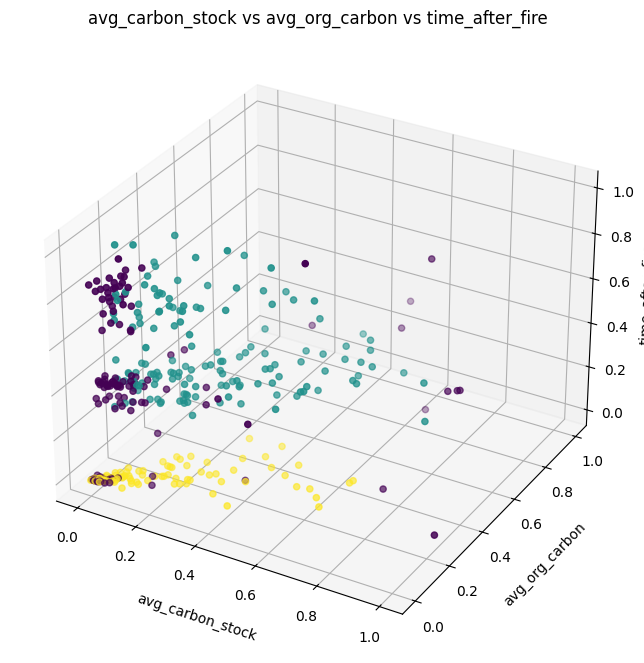

In [278]:
print("Graph for piba_prop_canopy")
pibaGraph = ["avg_carbon_stock", "avg_org_carbon", "piba_prop_canopy"]
plotData3D(newdataWithClusters, pibaGraph[0], pibaGraph[1], pibaGraph[2])

print("Graph for decid_prop_canopy")
decidGraph = ["avg_carbon_stock", "avg_org_carbon", "decid_prop_canopy"]
plotData3D(newdataWithClusters, decidGraph[0], decidGraph[1], decidGraph[2])


print("Graph for time_after_fire")
timeGraph = ["avg_carbon_stock", "avg_org_carbon", "time_after_fire"]
plotData3D(newdataWithClusters, timeGraph[0], timeGraph[1], timeGraph[2])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the dataset
data = pd.read_csv("SoilOrganicCarbonRecovery_NorthwestTerritories.csv")

# Drop any rows with missing data
data.dropna(inplace=True)

# Encoding categorical variables
label_encoders = {}
categorical_columns = ['plot', 'burn', 'site', 'stand_dominance', 'moisture', 'nonvascular_functionalgroup', 'ecozone']
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

In [4]:
# Splitting data into features and target variable
X = data.drop(columns=['date', 'avg_org_carbon'])
y = data['avg_org_carbon']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the Gradient Boosting Regressor
gbm = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 70, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the GBM model with the best hyperparameters
best_gbm = GradientBoostingRegressor(**best_params, random_state=42)
best_gbm.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = best_gbm.predict(X_test)

# Calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Evaluate performance using cross-validation (R^2 score)
cv_r2 = cross_val_score(best_gbm, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R^2 Score:", cv_r2.mean())

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 70}
Mean Squared Error: 24.280259151266172
Cross-Validation R^2 Score: 0.704743920683965


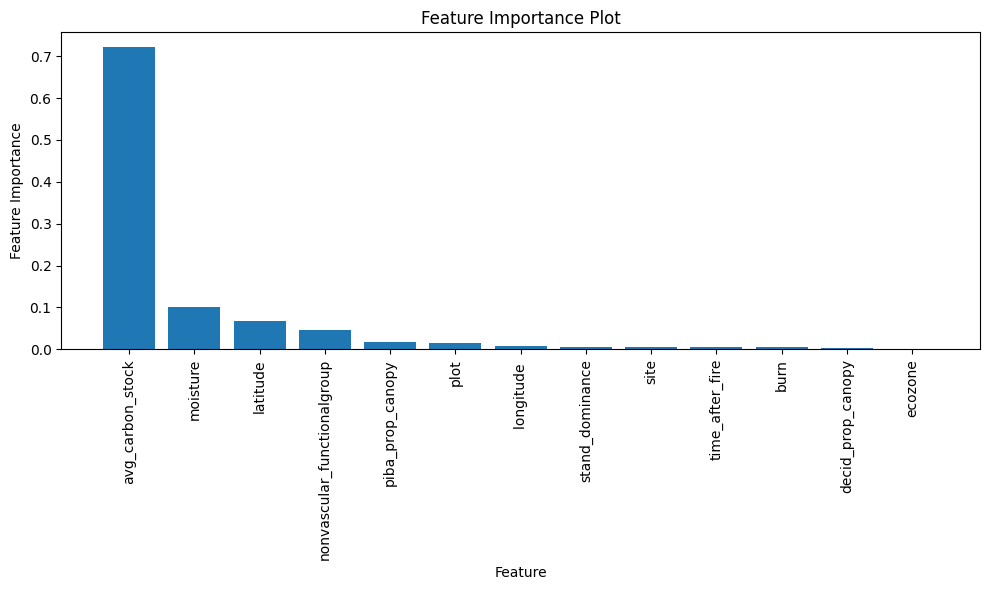

In [5]:
# Feature Importance Plot
# Extract feature importances
feature_importance = best_gbm.feature_importances_

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importance[sorted_idx], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.tight_layout()
plt.show()

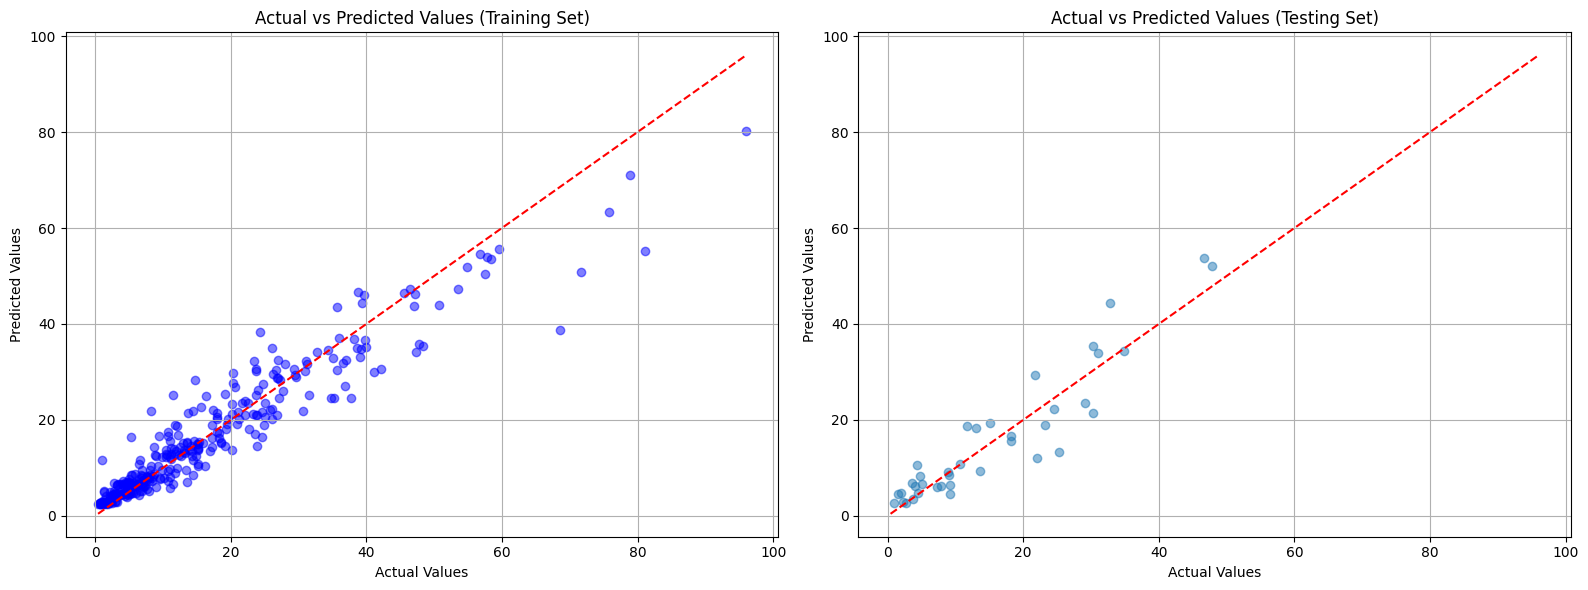

In [6]:
# Predict the values for the training set
y_train_pred = grid_search.predict(X_train)

# Predict the labels for the test set
y_pred_test = best_gbm.predict(X_test)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for training set
axs[0].scatter(y_train, y_train_pred, color='blue', alpha=0.5)
axs[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red')  # Diagonal line
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Actual vs Predicted Values (Training Set)')
axs[0].grid(True)

# Plot for testing set
axs[1].scatter(y_test, y_pred_test, alpha=0.5)
axs[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red')  # Diagonal line
axs[1].set_xlabel("Actual Values")
axs[1].set_ylabel("Predicted Values")
axs[1].set_title("Actual vs Predicted Values (Testing Set)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Splitting data into features and target variable
X1 = data.drop(columns=['date', 'avg_org_carbon', 'ecozone', 'burn', 'stand_dominance', 'decid_prop_canopy', 'plot', 'site', 'piba_prop_canopy', 'time_after_fire'])
y1 = data['avg_org_carbon']

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

# Initialize the Gradient Boosting Regressor
gbm1 = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters to tune
param_grid1 = {
    'n_estimators1': [50, 70, 100],
    'learning_rate1': [0.05, 0.1, 0.2],
    'max_depth1': [3, 4, 5]
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search1 = GridSearchCV(estimator=gbm1, param_grid=param_grid1, cv=5, scoring='neg_mean_squared_error')

# Perform hyperparameter tuning
grid_search.fit(X1_train, y1_train)

# Get the best hyperparameters
best_params1 = grid_search.best_params_
print("Best Hyperparameters:", best_params1)

# Train the GBM model with the best hyperparameters
best_gbm1 = GradientBoostingRegressor(**best_params1, random_state=42)
best_gbm1.fit(X1_train, y1_train)

# Predict the target variable for the test set
y1_pred = best_gbm1.predict(X1_test)

# Calculate the mean squared error of the model
mse1 = mean_squared_error(y1_test, y1_pred)
print("Mean Squared Error:", mse1)

# Evaluate performance using cross-validation (R^2 score)
cv1_r2 = cross_val_score(best_gbm1, X1_train, y1_train, cv=5, scoring='r2')
print("Cross-Validation R^2 Score:", cv1_r2.mean())

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 70}
Mean Squared Error: 27.18032738053802
Cross-Validation R^2 Score: 0.7114889226388178


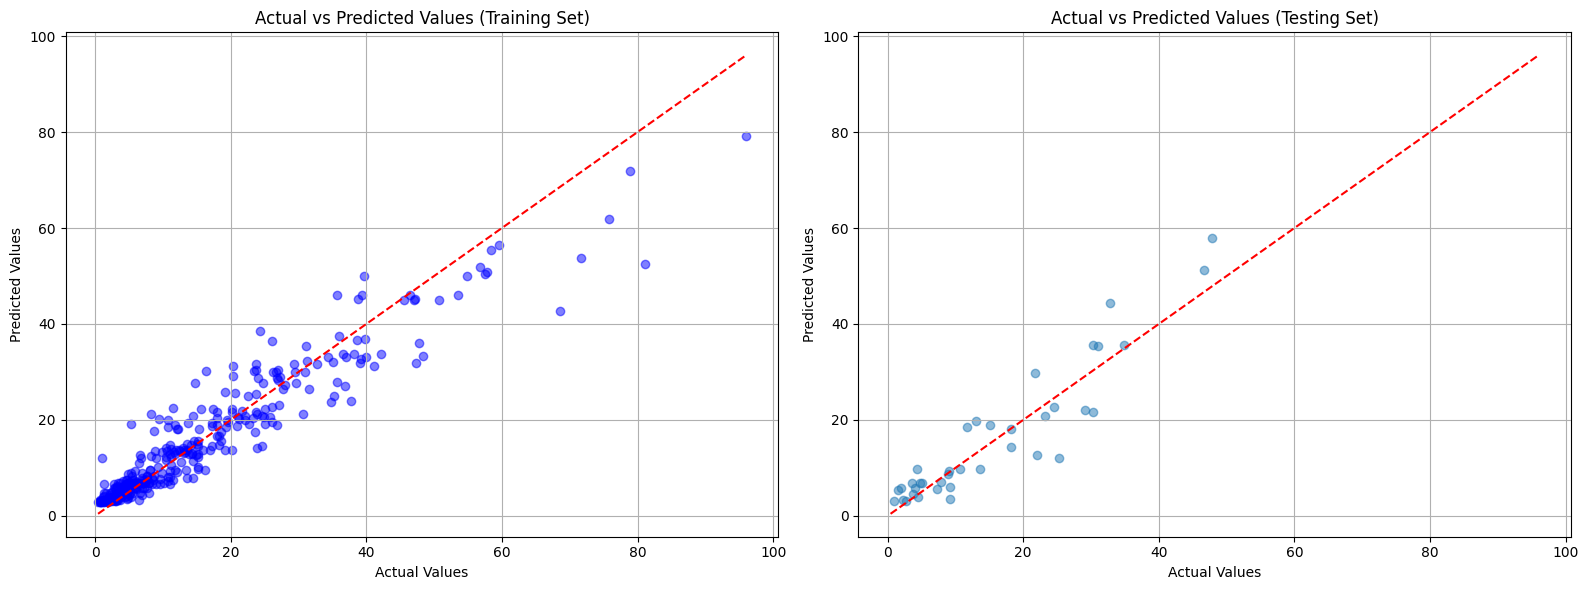

In [8]:
# Predict the values for the training set
y1_train_pred = grid_search.predict(X1_train)

# Predict the labels for the test set
y1_pred_test = best_gbm1.predict(X1_test)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for training set
axs[0].scatter(y1_train, y1_train_pred, color='blue', alpha=0.5)
axs[0].plot([min(y1_train), max(y1_train)], [min(y1_train), max(y1_train)], linestyle='--', color='red')  # Diagonal line
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Actual vs Predicted Values (Training Set)')
axs[0].grid(True)

# Plot for testing set
axs[1].scatter(y1_test, y1_pred_test, alpha=0.5)
axs[1].plot([min(y1_train), max(y1_train)], [min(y1_train), max(y1_train)], linestyle='--', color='red')  # Diagonal line
axs[1].set_xlabel("Actual Values")
axs[1].set_ylabel("Predicted Values")
axs[1].set_title("Actual vs Predicted Values (Testing Set)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Mean Squared Error: 24.80241621500797
R^2 Score: 0.8437393018748068


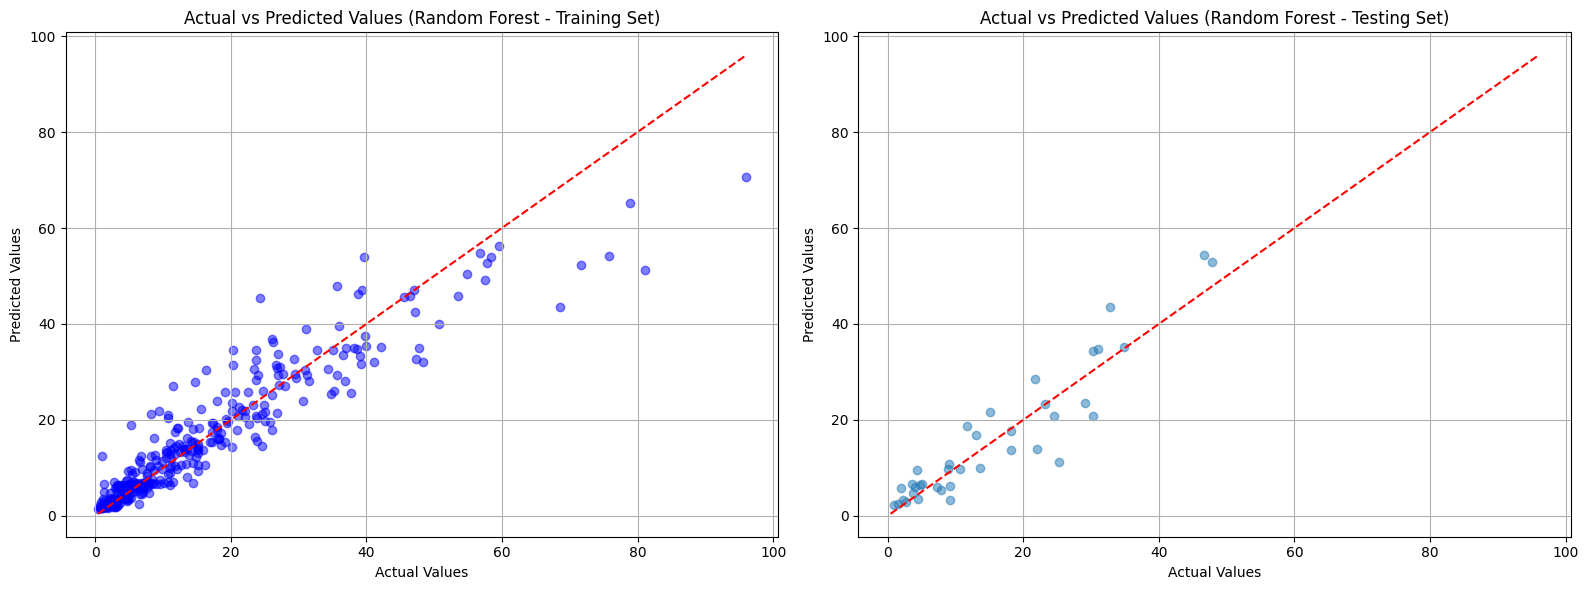

In [9]:
# Define Random Forest regressor
rf = RandomForestRegressor()

# Define hyperparameters grid for Random Forest
param_grid2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Perform hyperparameter tuning using GridSearchCV
grid_search2 = GridSearchCV(estimator=rf, param_grid=param_grid2, cv=5, scoring='neg_mean_squared_error')
grid_search2.fit(X1_train, y1_train)

# Get the best hyperparameters
best_params2 = grid_search2.best_params_

# Train Random Forest model with best hyperparameters
best_rf = RandomForestRegressor(**best_params2, random_state=42)
best_rf.fit(X1_train, y1_train)

# Make predictions on the training set
y1_train_pred = grid_search2.predict(X1_train)

# Make predictions on the testing set
y1_test_pred = best_rf.predict(X1_test)

# Evaluate model performance
mse2 = mean_squared_error(y1_test, y1_test_pred)
r22 = r2_score(y1_test, y1_test_pred)

print("Best Hyperparameters:", best_params2)
print("Mean Squared Error:", mse2)
print("R^2 Score:", r22)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for training set
axs[0].scatter(y1_train, y1_train_pred, color='blue', alpha=0.5)
axs[0].plot([min(y1_train), max(y1_train)], [min(y1_train), max(y1_train)], linestyle='--', color='red')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Actual vs Predicted Values (Random Forest - Training Set)')
axs[0].grid(True)

# Plot for testing set
axs[1].scatter(y1_test, y1_test_pred, alpha=0.5)
axs[1].plot([min(y1_train), max(y1_train)], [min(y1_train), max(y1_train)], linestyle='--', color='red')  # Diagonal line
axs[1].set_xlabel("Actual Values")
axs[1].set_ylabel("Predicted Values")
axs[1].set_title("Actual vs Predicted Values (Random Forest - Testing Set)")
axs[1].grid(True)

plt.tight_layout()
plt.show()